In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pytorch-forecasting ta optuna statsmodels optuna-integration[pytorch_lightning]

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.7/197.7 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.9/231.9 kB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.0/819.0 kB 58.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 121.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 93.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00

In [3]:
import os
import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import torch
import pytorch_lightning as pl

from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer, TorchNormalizer, MultiNormalizer
from pytorch_forecasting.metrics import SMAPE
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger

# TODO: Fill in the Google Drive path where you uploaded assignment1
# Example: If you create a Fall2023 folder and put all the files under A1 folder, then 'Fall2023/A1'
GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'capstone_project'
user = 'ydosi3'
if user == 'ydosi3':
  GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive',
                                   'MyDrive/Colab Notebooks', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
else:
  GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive',
                                   GOOGLE_DRIVE_PATH_POST_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

import sys
sys.path.append(GOOGLE_DRIVE_PATH)

os.environ['GOOGLE_DRIVE_PATH'] = GOOGLE_DRIVE_PATH

os.environ['GOOGLE_DRIVE_PATH']

['yash-deepar-training.ipynb', 'yash-tft-training.ipynb', 'data', 'utils', 'src', 'data_processing.ipynb', 'model', 'models_results', 'notebooks', '__pycache__', 'MarketSimulator.py', 'E2E_Pipeline.ipynb', 'E2E_Pipeline_manik.ipynb']


'/content/drive/MyDrive/Colab Notebooks/capstone_project'

In [4]:
# hyperparams
TRAINING_DATA_RATIO = 0.85
VALIDATION_DATA_RATIO = 0.15
# TESTING_DATA_RATIO = 0.1

data_base = f"{os.environ['GOOGLE_DRIVE_PATH']}/data"
data = pd.read_csv(f"{data_base}/NIFTY 50_minute_data.csv", parse_dates=['date'])
data['cal_date'] = pd.to_datetime(data['date'].dt.date)

daily_data = pd.read_csv(f"{data_base}/NIFTY 50_daily_data.csv", parse_dates=['date'])
daily_data['date'] = pd.to_datetime(daily_data['date'])
# Calculate the percentage gap between the current day's open and the previous day's close
daily_data['previous_close'] = daily_data['close'].shift(1)
daily_data['gap_percentage'] = ((daily_data['open'] - daily_data['previous_close']) / daily_data['previous_close']) * 100

gap_threshold = 0.7
# Categorize the gap as 'gap_up', 'gap_down', or 'no_gap'
daily_data['gap_type'] = np.where(daily_data['gap_percentage'] > gap_threshold, 'gap_up',
                                 np.where(daily_data['gap_percentage'] < -gap_threshold, 'gap_down', 'no_gap'))

vix_min = pd.read_csv(f"{data_base}/INDIA VIX_minute.csv", parse_dates=['date'])
# Rename columns in the 'data' DataFrame
vix_min = vix_min.rename(columns={
    'date': 'vix_date',
    'open': 'vix_open',
    'high': 'vix_high',
    'low': 'vix_low',
    'close': 'vix_close',
    'volume': 'vix_volume'
})
vix_min.drop(columns=['vix_volume'], inplace=True)

In [5]:
# Rename columns in the 'data' DataFrame
data = data.rename(columns={
    'date': 'min_date',
    'open': 'min_open',
    'high': 'min_high',
    'low': 'min_low',
    'close': 'min_close',
    'volume': 'min_volume'
})
data['hour'] = data['min_date'].dt.hour
data['hour'] = data['hour'].astype(str)

data["hour_start"] = data["min_date"].dt.floor("h")
# Calculate the return from the start of the hour
data = data.merge(data.groupby("hour_start")["min_close"].first(), on="hour_start", suffixes=("", "_start"))
data["hourly_return"] = (data["min_close"] - data["min_close_start"]) / data["min_close_start"]

In [6]:
merged_data = pd.merge(data, daily_data, left_on='cal_date', right_on='date', how='left')
merged_data = pd.merge(merged_data, vix_min, left_on='min_date', right_on='vix_date', how='left')
merged_data = merged_data.drop(['volume', 'min_volume', 'previous_close', 'open', 'high', 'low',
                                'close', 'date', 'cal_date', 'vix_date', 'hour_start'], axis=1)
merged_data = merged_data.rename(columns={
    'min_open': 'open',
    'min_high': 'high',
    'min_low': 'low',
    'min_close': 'close',
})

In [7]:
RSI_WINDOW = 30
EMA_1 = 60
EMA_2 = 120
MACD_SLOW_WINDOW = 120
MACD_FAST_WINDOW = 45
MACD_SIGNAL_WINDOW = 9
STOCH_WINDOW = 45

merged_data["stock"] = "NIFTY_IDX"

# Calculate RSI
merged_data['RSI'] = ta.momentum.RSIIndicator(merged_data['close'], window=RSI_WINDOW).rsi()

# Calculate MACD
macd = ta.trend.MACD(merged_data['close'], window_slow=MACD_SLOW_WINDOW,
                     window_fast=MACD_FAST_WINDOW, window_sign=MACD_SIGNAL_WINDOW)
merged_data['MACD'] = macd.macd()
merged_data['MACD_signal'] = macd.macd_signal()
merged_data['MACD_diff'] = macd.macd_diff()

# Calculate Stochastic Oscillator
stoch = ta.momentum.StochasticOscillator(merged_data['high'], merged_data['low'], merged_data['close'], window=STOCH_WINDOW)
merged_data['stoch'] = stoch.stoch()
merged_data['stoch_signal'] = stoch.stoch_signal()

# Add ema slow and fast
merged_data['ema_slow'] = ta.trend.EMAIndicator(merged_data['close'], window=EMA_2).ema_indicator()
merged_data['ema_fast'] = ta.trend.EMAIndicator(merged_data['close'], window=EMA_1).ema_indicator()

merged_data.dropna(axis=0, how='any', inplace=True)

# add index column
merged_data["time_idx"] = merged_data.index


In [8]:
# prompt: shift all the ema_slow and ema_fast values ahead by 10 steps

merged_data['ema_slow_a'] = merged_data['ema_slow'].shift(10)
merged_data['ema_fast_a'] = merged_data['ema_fast'].shift(10)
merged_data['MACD_a'] = merged_data['MACD'].shift(10)
merged_data['MACD_signal_a'] = merged_data['MACD_signal'].shift(10)
merged_data['MACD_diff_a'] = merged_data['MACD_diff'].shift(10)
merged_data['stoch_a'] = merged_data['stoch'].shift(10)
merged_data['stoch_signal_a'] = merged_data['stoch_signal'].shift(10)
merged_data['vix_close_a'] = merged_data['vix_close'].shift(10)
merged_data.dropna(axis=0, how='any', inplace=True)


In [9]:
merged_data[['ema_slow', 'ema_slow_a']].head(15)

,ema_slow,ema_slow_a
137,8281.340096,8284.689072
138,8280.851830,8284.454542
139,8280.433618,8284.158599
140,8280.093392,8283.830358
141,8279.730692,8283.542253
142,8279.332664,8283.268001
143,8278.892454,8282.989191
144,8278.446298,8282.687717
145,8278.024872,8282.215192
146,8277.664130,8281.828164


In [10]:
import math

def calculate_batch_size(total_samples, target_batch_count=100):
    """Calculates the batch size as the nearest power of 2 for 100 batches.

    Args:
        total_samples: The total number of samples.

    Returns:
        The calculated batch size.
    """

    ideal_batch_size = total_samples // target_batch_count
    power_of_two = round(math.log2(ideal_batch_size))
    batch_size = 2**power_of_two
    return batch_size


In [11]:
column_list = [
    'open', 'high', 'low', 'close', 'gap_percentage', 'gap_type',
    'vix_open', 'vix_high', 'vix_low', 'vix_close', 'hour',
    'min_close_start', 'hourly_return', 'RSI', 'MACD', 'MACD_signal',
    'MACD_diff', 'stoch', 'stoch_signal', 'ema_slow', 'ema_fast', 'stock',
    'ema_slow_a', 'ema_fast_a', 'MACD_a', 'MACD_signal_a', 'MACD_diff_a',
    'stoch_a', 'stoch_signal_a', 'vix_close_a'
]

# column_list = [
#     'open', 'close', 'stock',  'high', 'low'
# ]
forecast_window = 10 # days
lookback_factor = 5
forecast_start_date = pd.to_datetime('2022-04-01')

lookback_window = max(180, forecast_window * lookback_factor)
forecast_end_date = forecast_start_date + pd.DateOffset(days=forecast_window)

training_start_date = forecast_start_date - pd.DateOffset(days=lookback_window)
# training_end_date = forecast_end_date - pd.DateOffset(days=lookback_window)

print(f"training start date: {training_start_date}")
print(f"training end date: {forecast_start_date}")
print(f"forecast start date: {forecast_start_date}")
print(f"forecast end date: {forecast_end_date}")
df1 = merged_data[merged_data['min_date'] < forecast_start_date]
df1 = df1[df1['min_date'] >= training_start_date]
df2 = merged_data[merged_data['min_date'] >= forecast_start_date]
df2 = df2[df2['min_date'] < forecast_end_date]
data1 = df1[column_list]
test_df = df2[column_list]

TOTAL_DATA_LEN = data1.shape[0]

# # add index column
# data1["time_idx"] = data1.index
# test_df["time_idx"] = test_df.index

df = data1[:TOTAL_DATA_LEN]

train_df = df[:int(TOTAL_DATA_LEN*TRAINING_DATA_RATIO)]
val_df = df[int(TOTAL_DATA_LEN*TRAINING_DATA_RATIO):
            int(TOTAL_DATA_LEN*(TRAINING_DATA_RATIO+VALIDATION_DATA_RATIO))]

train_df.reset_index()
train_df["time_idx"] = train_df.index

val_df.reset_index()
val_df["time_idx"] = val_df.index

test_df.reset_index()
test_df["time_idx"] = test_df.index
# test_df = df[int(TOTAL_DATA_LEN*(TRAINING_DATA_RATIO+VALIDATION_DATA_RATIO)):]

training start date: 2021-10-03 00:00:00
training end date: 2022-04-01 00:00:00
forecast start date: 2022-04-01 00:00:00
forecast end date: 2022-04-11 00:00:00


<ipython-input-11-61dd31c5a9b6>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df["time_idx"] = train_df.index
<ipython-input-11-61dd31c5a9b6>:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df["time_idx"] = val_df.index
<ipython-input-11-61dd31c5a9b6>:53: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

In [12]:
print("Close Column Statistics:")
print(f"Minimum: {train_df['close'].min()}")
print(f"Maximum: {train_df['close'].max()}")
print(f"Mean: {train_df['close'].mean()}")
print(f"Median: {train_df['close'].median()}")
# Calculate mode - it might have multiple modes
from scipy import stats
mode_result = stats.mode(train_df['close'])
# print(mode_result)
print(f"Mode: {mode_result.mode} (count: {mode_result.count})")


Close Column Statistics:
Minimum: 16134.95
Maximum: 18592.15
Mean: 17548.656631565427
Median: 17524.85
Mode: 17326.85 (count: 10)


In [13]:
print("Close Column Statistics:")
print(f"Minimum: {val_df['close'].min()}")
print(f"Maximum: {val_df['close'].max()}")
print(f"Mean: {val_df['close'].mean()}")
print(f"Median: {val_df['close'].median()}")
# Calculate mode - it might have multiple modes
from scipy import stats
mode_result = stats.mode(val_df['close'])
# print(mode_result)
print(f"Mode: {mode_result.mode} (count: {mode_result.count})")

Close Column Statistics:
Minimum: 15674.25
Maximum: 17556.8
Mean: 16894.295124436037
Median: 17069.45
Mode: 15785.4 (count: 26)


In [14]:
from torchmetrics.regression import MeanSquaredError
from pytorch_forecasting.data import TimeSeriesDataSet
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scalers = {
    'open': MinMaxScaler(),
    'high': MinMaxScaler(),
    'low': MinMaxScaler(),
    # 'close': MinMaxScaler(),
    'vix_open': MinMaxScaler(),
    'vix_high': MinMaxScaler(),
    'vix_low': MinMaxScaler(),
    # 'vix_close': MinMaxScaler(),
    'RSI': MinMaxScaler(),
    'MACD': MinMaxScaler(),
    'MACD_signal': MinMaxScaler(),
    'MACD_diff': MinMaxScaler(),
    'stoch': MinMaxScaler(),
    'stoch_signal': MinMaxScaler(),
    'ema_slow': MinMaxScaler(),
    'ema_fast': MinMaxScaler(),
    'ema_slow_a': MinMaxScaler(),
    'ema_fast_a': MinMaxScaler(),
    # 'vix_open': MinMaxScaler(),
    # 'vix_high': MinMaxScaler(),
    # 'vix_low': MinMaxScaler(),
    'vix_close_a': MinMaxScaler(),
    # 'RSI': MinMaxScaler(),
    'MACD_a': MinMaxScaler(),
    'MACD_signal_a': MinMaxScaler(),
    'MACD_diff_a': MinMaxScaler(),
    'stoch_a': MinMaxScaler(),
    'stoch_signal_a': MinMaxScaler(),
}

In [15]:
from pytorch_forecasting.models import DeepAR

# create dataset and dataloaders
max_encoder_length = 60
max_prediction_length = 10
training_data = TimeSeriesDataSet(
    train_df,
    time_idx="time_idx",
    # target=['close', 'vix_close'],
    target='close',
    group_ids=["stock"],
    # Fixed history and forecast lengths:
    # min_encoder_length=max_encoder_length//2,
    max_encoder_length=max_encoder_length,
    # min_prediction_length=1,
    max_prediction_length=max_prediction_length,
    # In our setting we assume that only the time index is known
    # (you could add additional known features if available)
    # time_varying_known_reals=["time_idx"],
    # time_varying_known_reals=['vix_close_a', ],
                              # 'MACD_signal_a', 'MACD_diff_a', 'stoch_a',
                              # 'stoch_signal_a', ],
    # Historical features (OHLC and the extra indicators) are unknown in the future and help inform past behavior
    time_varying_unknown_reals=['close'],
    # time_varying_unknown_reals=['open', 'high', 'low', 'close', 'vix_open',
    #                             'vix_high', 'vix_low', 'vix_close'],
    # time_varying_known_categoricals=['gap_type', 'hour'],
    # Normalize the target by group. Softplus ensures non-negative predictions.
    target_normalizer=GroupNormalizer(
        groups=["stock"], transformation="softplus"
    ),
    # target_normalizer=MultiNormalizer(
    #     [MinMaxScaler(), MinMaxScaler()],
    # ),
    allow_missing_timesteps=True,
    # scalers=scalers,
    # add_relative_time_idx=True,
    # add_target_scales=True,
    # add_encoder_length=True,
)

# Create dataloaders for training and validation:
batch_size = calculate_batch_size(train_df.shape[0], 200)
print(f"Batch size: {batch_size}")
train_dataloader = training_data.to_dataloader(train=True, batch_size=batch_size,
                                               num_workers=0)

# Build the validation dataset from the same dataset (ensuring consistent preprocessing)
validation_data = TimeSeriesDataSet.from_dataset(
    training_data, val_df, stop_randomization=True, predict=True,
    # min_encoder_length=max_encoder_length//2,
    max_encoder_length=max_encoder_length,
    # min_prediction_length=1,
    max_prediction_length=max_prediction_length
)

valid_dataloader = validation_data.to_dataloader(batch_size=batch_size,
                                                 num_workers=0, train=False)

# configure network and trainer
pl.seed_everything(42)
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4,
                                    patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()  # log the learning rate
logger = TensorBoardLogger("lightning_logs")

l = "smape"

# Wrap the TFT model with the PyTorch Lightning module
class ModelLightningModule(pl.LightningModule):
    def __init__(self, tft):
        super().__init__()
        # self.tft = tft
        self.model = tft
        self.train_losses_per_epoch = []
        self.validation_losses_per_epoch = []
        # self.save_hyperparameters(ignore=["model", "loss", "logging_metrics"])

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.model.loss(y_hat["prediction"], y)
        self.log("train_loss", loss, on_epoch=True, prog_bar=True,
                 batch_size=x['encoder_target'].shape[0])
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        # print(y_hat["prediction"][:, :, 0])
        # print(y)
        # loss = MeanSquaredError().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))(y_hat["prediction"][:, :, 0], y[0])
        loss = self.model.loss(y_hat["prediction"], y)
        self.log("val_loss", loss, prog_bar=True, batch_size=x['encoder_target'].shape[0])
        return loss

    def test_step(self, batch, batch_idx):
        # Perform a single test step
        x, y = batch
        out = self.model(x)
        y_pred = out[0]  # The model output is a tuple, 'y_pred' is the first element
        # loss = MeanSquaredError().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))(y_pred, y)
        loss = self.model.loss(y_pred["prediction"], y)
        self.log("test_loss", loss, prog_bar=True, batch_size=x['encoder_target'].shape[0])
        return loss

    def on_train_epoch_end(self):
        self.train_losses_per_epoch.append(self.trainer.callback_metrics['train_loss'].item())
        self.validation_losses_per_epoch.append(self.trainer.callback_metrics['val_loss'].item())

    def configure_optimizers(self):
        return self.model.configure_optimizers()

# initialise DeepAR model
deepar = DeepAR.from_dataset(
    training_data,
    learning_rate=0.2,
    hidden_size=16,
    rnn_layers=2,
    dropout=0.1,
    log_interval=10,
    # loss=MeanSquaredError() if l == "mse" else SMAPE(),
    # time_varying_reals_encoder=['close'],
    # time_varying_reals_decoder=['close']
    # cell_type="GRU"
).to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# Configure a PyTorch Lightning Trainer:
trainer = pl.Trainer(
    max_epochs=20,
    gradient_clip_val=0.01,
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
)

# Create an instance of the Lightning module, wrapping the TFT model
deepar_lightning_module = ModelLightningModule(deepar)

# fit network
trainer.fit(
    deepar_lightning_module,
    train_dataloaders=train_dataloader,
    val_dataloaders=valid_dataloader,
)


INFO:lightning_fabric.utilities.seed:Seed set to 42


Batch size: 256


/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/usr/local/lib/python3.11/dist-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_l

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=20` reached.


In [16]:
best_model_path = trainer.checkpoint_callback.best_model_path
print(f"Best model path: {best_model_path}")

best_model = ModelLightningModule.load_from_checkpoint(best_model_path, tft=deepar)
# Now 'best_model' contains the best performing model


Best model path: lightning_logs/lightning_logs/version_0/checkpoints/epoch=19-step=3020.ckpt


In [43]:
import os
# Save the trained model
model_save_path = f"{GOOGLE_DRIVE_PATH}/models_results/checkpoints/ydosi3-deepar-v4.ckpt"
trainer.save_checkpoint(model_save_path)
print(f"Model saved to: {model_save_path}")

Model saved to: /content/drive/MyDrive/Colab Notebooks/capstone_project/models_results/checkpoints/ydosi3-deepar-v4.ckpt


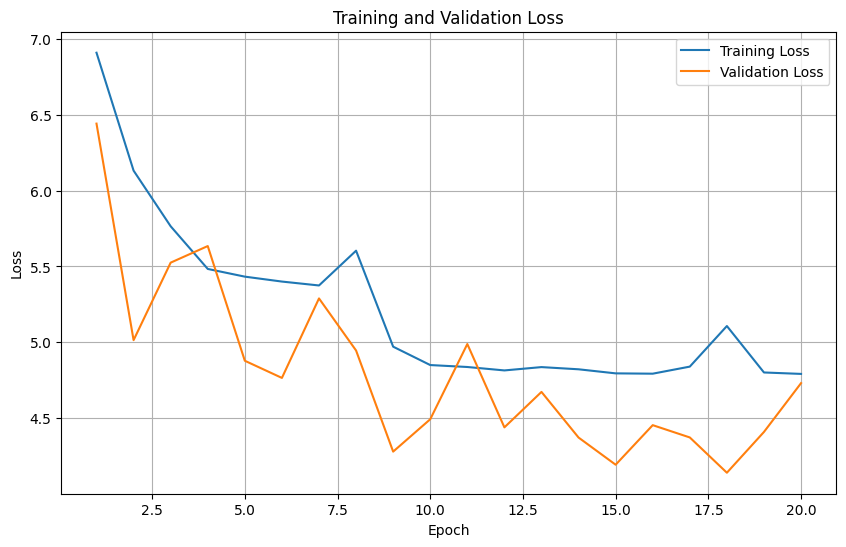

In [17]:
train_losses = deepar_lightning_module.train_losses_per_epoch
val_losses = deepar_lightning_module.validation_losses_per_epoch

# Create epoch array
epochs = range(1, len(train_losses) + 1)

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


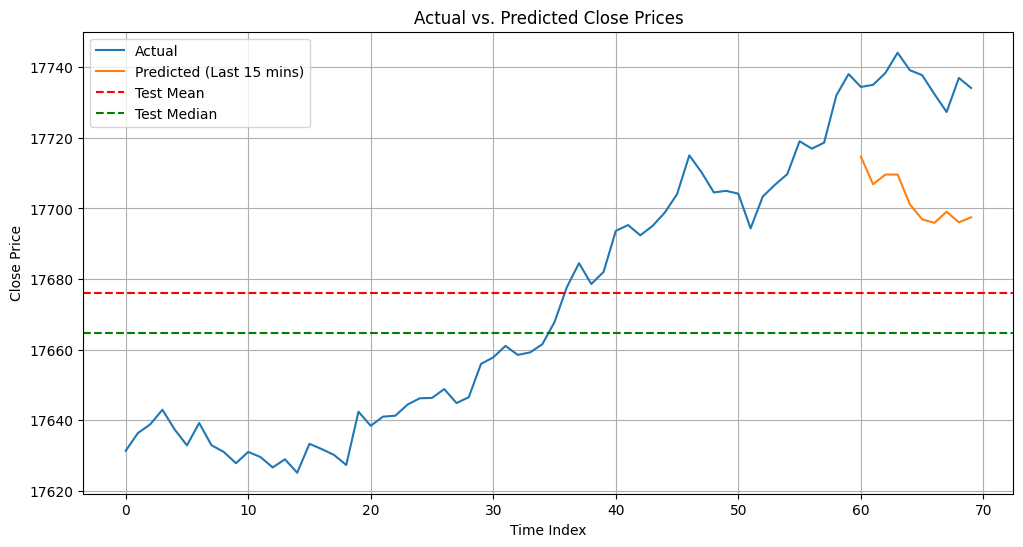

In [18]:
start = 2000
input_context = 60
test_df1 = test_df[start:start+max_prediction_length+input_context]

test_data = TimeSeriesDataSet.from_dataset(
    training_data,
    test_df1,
    predict=True,
    stop_randomization=True,
    # min_encoder_length=24,
    # max_encoder_length=24,
    # min_prediction_length=6,
    # max_prediction_length=6
)

test_dataloader = test_data.to_dataloader(batch_size=1, num_workers=0, train=False)

# Get predictions
predictions = best_model.model.predict(test_dataloader)
# predictions = deepar.predict(test_dataloader, dtype=torch.float32)
# raw_predictions = tft.predict(test_dataloader, mode="raw", return_x=True, trainer_kwargs=dict(accelerator="cpu"))

predicted_close = predictions  # Example: Assuming a single output

# Determine the indices for the last 15 minutes of predictions
prediction_indices = range(input_context, len(test_df1))
actual_indices = range(0, len(test_df1))

# Plot actual and predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual_indices, test_df1['close'], label='Actual')
plt.plot(list(prediction_indices), predicted_close.tolist()[0], label='Predicted (Last 15 mins)')
# add horizontal line
plt.axhline(y=test_df1['close'].mean(), color='r', linestyle='--', label='Test Mean')
plt.axhline(y=test_df1['close'].median(), color='g', linestyle='--', label='Test Median')
# plt.axhline(y=train_df['close'].mean(), linestyle=':', label='Train Mean')
# plt.axhline(y=train_df['close'].median(), linestyle='-.', label='Train Median')
plt.xlabel("Time Index")
plt.ylabel("Close Price")
plt.title("Actual vs. Predicted Close Prices")
plt.legend()
plt.grid(True)
plt.show()


In [19]:
def run_model_prediction(model, pred_input_df):
    """
    - preds: torch.Tensor of shape (1, pred_len, num_quantiles)
    """
    test_data = TimeSeriesDataSet.from_dataset(
        training_data,
        pred_input_df,
        predict=True,
        stop_randomization=True,
        # min_encoder_length=24,
        # max_encoder_length=24,
        # min_prediction_length=6,
        # max_prediction_length=6
    )

    test_dataloader = test_data.to_dataloader(batch_size=1, num_workers=0, train=False)

    # Get predictions
    predictions = best_model.model.predict(test_dataloader)
    return predictions

def reshape_forecast_for_cnn(forecast_tensor):
    """
    Input: forecast_tensor of shape (1, T, Q) or (T, Q=3)
    Output: reshaped tensor of shape (T, 4) for CNN
    """
    if isinstance(forecast_tensor, np.ndarray):
        forecast_np = forecast_tensor
    else:
        forecast_np = forecast_tensor.detach().cpu().numpy()

    if forecast_np.ndim == 3:
        forecast_np = forecast_np.squeeze(0)  # (T, Q)

    # Add 4th channel (mean of quantiles)
    #avg_col = np.mean(forecast_np, axis=-1, keepdims=True)
    #cnn_input = np.concatenate([forecast_np, avg_col], axis=-1)  # (T, 4)
    #print(cnn_input)
    return torch.tensor(forecast_np, dtype=torch.float32)

In [23]:
def calculate_z_score(df, column, lookback_window):
    if column not in df.columns:
        raise ValueError(f"Column '{column}' does not exist in the DataFrame.")

    # Calculate the rolling mean and standard deviation
    rolling_mean = df[column].rolling(window=lookback_window).mean()
    rolling_std = df[column].rolling(window=lookback_window).std()

    # Calculate the Z-score
    df['zscore'] = (df[column] - rolling_mean) / rolling_std
    return df


def enrich_tensor_cnn(close_tensor):
    B, window, _ = close_tensor.shape
    enriched = []

    for i in range(B):
        close = close_tensor[i, :, 0].cpu().numpy()
        df = pd.DataFrame({'close': close})

        # Calculate indicators
        df["ema"] = ta.trend.EMAIndicator(merged_data['close'], window=15).ema_indicator()
        df["rsi"] = ta.momentum.RSIIndicator(merged_data['close'], window=15).rsi()
        calculate_z_score(df, 'close', lookback_window=15)

        df.bfill(inplace=True)
        df.fillna(0, inplace=True)

        enriched.append(df[['close','ema','rsi','zscore']].values)

    enriched_tensor = torch.tensor(np.stack(enriched), dtype=torch.float32).to(close_tensor.device)
    return enriched_tensor


In [35]:
from MarketSimulator import *
# from src.forecasting.Scalers import enrich_tensor_cnn
from utils.classify_window import classify_window

WINDOW_SIZE = 10
PATTERN_LABELS = ['head_and_shoulders', 'double_bottom', 'ascending_triangle', 'none']

def extract_windows(df, seq_len, step_size):
    windows = []
    for start in range(0, len(df) - seq_len + 1, step_size):
        end = start + seq_len
        window = df.iloc[start:end].copy()
        windows.append(window)
    return windows

num_days = 10
trading_hrs = 6.5
simulation_data_size = int(60 * trading_hrs * num_days) # minutes * hrs * days
window_seq_length = 70
step_size = WINDOW_SIZE

# Start at index 0 and then slide the window of size(WINDOW_SIZE) by step_size steps
simulation_windows = extract_windows(test_df, window_seq_length, step_size)

simulation_data = []

for fcast in simulation_windows:

    classified_forecast = dict()

    #forecast = run_model_prediction(model, scaler, fcast,feature_cols, window_seq_length)
    # fcast_tensor = torch.tensor(fcast['close'].values, dtype=torch.float32)
    # fcast_tensor = fcast_tensor.unsqueeze(0).unsqueeze(2)

    forecast = run_model_prediction(best_model.model, fcast)
    classified_forecast['window'] = fcast['close']
    classified_forecast['forecast'] = forecast.unsqueeze(2).cpu()
    classified_forecast['label'] = classify_window(
        reshape_forecast_for_cnn(enrich_tensor_cnn(forecast.unsqueeze(2))),
        model_type='2d',
        model_path=f"{GOOGLE_DRIVE_PATH}/models_results/checkpoints/CNN2D_MULTICHANNEL.pt",
        PATTERN_LABELS=PATTERN_LABELS)
    simulation_data.append(classified_forecast)


INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:lightning.pytorch.accelerators

In [36]:
simulation_data[-1]['forecast']

tensor([[[17777.1699],
         [17766.9941],
         [17765.1602],
         [17762.2754],
         [17760.8145],
         [17759.5820],
         [17759.3828],
         [17755.2715],
         [17749.9355],
         [17746.1992]]])

In [37]:
trader = Trader()

# have to use a very high price tolerance as the forecast is way off the actual close price
simulator = MarketSimulator(processed_data=simulation_data, initial_budget=100000, price_tolerance=5000)

trade_log = simulator.simulate()

In [38]:
trade_log

[(111, 'buy', np.float64(17789.771484375), np.float64(82210.228515625)),
 (111, 'sell', np.float64(17789.771484375), np.float64(100000.0)),
 (113, 'buy', np.float64(17805.23046875), np.float64(82194.76953125)),
 (113, 'sell', np.float64(17805.23046875), np.float64(100000.0)),
 (116, 'buy', np.float64(17763.658203125), np.float64(82236.341796875)),
 (116, 'sell', np.float64(17766.216796875), np.float64(100002.55859375)),
 (118, 'buy', np.float64(17787.369140625), np.float64(82215.189453125)),
 (118, 'sell', np.float64(17787.369140625), np.float64(100002.55859375)),
 (129, 'buy', np.float64(17812.861328125), np.float64(82189.697265625)),
 (129, 'sell', np.float64(17812.861328125), np.float64(100002.55859375)),
 (130, 'buy', np.float64(17791.78515625), np.float64(82210.7734375)),
 (130, 'sell', np.float64(17791.78515625), np.float64(100002.55859375)),
 (133, 'buy', np.float64(17791.51953125), np.float64(82211.0390625)),
 (133, 'sell', np.float64(17791.51953125), np.float64(100002.55859375

In [48]:
trade_log_df = pd.DataFrame(trade_log, columns=['idx', 'signal', 'price', 'portfolio'])
trade_log_df.head()

,idx,signal,price,portfolio
0,111,buy,17789.771484,82210.228516
1,111,sell,17789.771484,100000.000000
2,113,buy,17805.230469,82194.769531
3,113,sell,17805.230469,100000.000000
4,116,buy,17763.658203,82236.341797


In [51]:
log_file_path = f"{GOOGLE_DRIVE_PATH}/models_results/checkpoints/ydosi3-deepar-trade.log"
trade_log_df.to_csv(log_file_path, index=False)  # Save to CSV, without the index
print(f"Trade log saved to: {log_file_path}")


Trade log saved to: /content/drive/MyDrive/Colab Notebooks/capstone_project/models_results/checkpoints/ydosi3-deepar-trade.log
